In [3]:
"""
The WALK project has the challenge of taking a number of web archives collections and making them usable for historical
(or other) kinds of research. Web archives are a way of storing websites over time. They do this by periodically crawling 
websites on different dates. For instance, your blog probably has a lot of new information today than it did five years
ago.  A web archive would (in theory) be able to show what your blog looked like now (with a crawl date 2016) and then 
(crawl date 2011).  The problem is what if we had a collection of all history blogs?  That's a lot of information! And
files that would store that information would be huge. 

Now imagine yourself being a graduate level historian in 2050, doing a paper on what amateur historians were interested 
in from the period of 2011-2016. You ask
for the collection of history blogs and you get a web archives file (also called a .WARC file) that's in the realm of 500
Gigabytes or more. You might want to give up already! Fortunately, you learn that there is a tool called Warcbase 
(http://lintool.github.io/warcbase-docs/) that will help you pull things out of the files.  For example, maybe you just
want all the links used to do a network analysis.  Or perhaps you prefer just the text so you can do some word cluster 
analysis. It's still complex - files like these often run in the 100s of MBs. Or you can do Name-entity Recognition (NER)
and explore what people, locations and subjects are mentioned.

We still have a problem. We know that social media are full of filter bubbles.  Maybe our historian bloggers are all
biased towards the same subjects! What if we could compare what those historians say and link to 
against other related bloggers - say 
archeologists, economists, political scientists, sociologists and anthropologists? 
Then we could have a more complete view of what this world is all about. But how?

This Compare class is a first crack at solving this problem using (soon to be multiple!) correspondence analysis and
venn diagrams. Instead of bloggers, we are looking at some web archive collections collected by the University of Alberta
and the University of Toronto.

"""

"\nThe WALK project has the challenge of taking a number of web archives collections and making them usable for historical\n(or other) kinds of research. Web archives are a way of storing websites over time. They do this by periodically crawling \nwebsites on different dates. For instance, your blog probably has a lot of new information today than it did five years\nago.  A web archive would (in theory) be able to show what your blog looked like now (with a crawl date 2016) and then \n(crawl date 2011).  The problem is what if we had a collection of all history blogs?  That's a lot of information! And\nfiles that would store that information would be huge. \n\nNow imagine yourself being a graduate level historian in 2050, doing a paper on what amateur historians were interested \nin from the period of 2011-2016. You ask\nfor the collection of history blogs and you get a web archives file (also called a .WARC file) that's in the realm of 500\nGigabytes or more. You might want to give up

In [4]:
"""
First we get our script ready with all the libraries we need. If you know Python, you are probably familiar with
most of these files.
"""

### For these import to work, you should have a copy of Anaconda available to you.  We are using Python 3 in this case.
### Also, you will need to install mca and matplotlib_venn.  See the README file for more information.

%matplotlib inline
import os
import csv
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
import mca
import matplotlib.pyplot as plt
from collections import defaultdict


In [26]:
###################################
## The main class
###################################

class Compare:
    """ 
    Compare -- plot collections for comparison purposes.
    
    Description:
        The purpose of this class is to take a series of collections and plot them so to show how they match.
        If the series is a dictionary, the keys will be used to create plot names.
        If the series contains two or three collections, then the plot will show venn diagrams and return a venn object
        that can be used for other purposes.
        If the series is greater than three, the plot will show the collections in a scatter plot based on correspondence
        scores.
    
    Parameters: 
        collections (required):  A list of lists or a dict() of size 2 or greater for comparison purposes. 
        names:  An optional list of names for the collections.  Must be equal in size to collections. If collections is 
            a dict, this parameter will be overwritten.
        index:  A list of index keys to create a sublist for the collections.
        var: An optional list for further categorization of the collection data (not fully implemented yet).
        REMOVE_SINGLES: (Default:True) For 4 collections or more, remove from the analysis any data points that are
            members of only one collection. This reduces the chance that a disproportionately large collection
            will be seen as an outlier merely because it is disproportionately large.
            
    """
    
    def __init__ (self, collections, names=[], index=[], var=[], REMOVE_SINGLES=True, LABEL_BOTH_FACTORS=False):
        self.collection_names = names
        self.index = index
        self.collections = collections
        self.REMOVE_SINGLES = REMOVE_SINGLES
        self.LABEL_BOTH_FACTORS = LABEL_BOTH_FACTORS
        self.dimensions = None
        #self.cur_depth = self.recur_len(self.collections)
        if isinstance(self.collections, dict):
            # print("dict passed")
            self.collection_names = [x for x in self.collections.keys()]
            self.collections = [x for x in self.collections.values()]
        #print(type([y[0] for y in self.collections][0]))
        # if a dictionary is inputed, then get names from dictionary
        if type([y[0] for y in self.collections][0]) is tuple: #will need to include checks for size of sample 
            print ("yay mca")
            self.collection_names = list(set([x[0] for y in self.collections for x in y]))            
            if self.index:
                self.collections = self.sublist(self.collections, self.index)
                self.collection_names = self.sublist(self.collection_names, self.index)
            self.mca(self.collections, self.collection_names)
        else:            
            #self.collections = dict([(x[0], x[1]) for y in self.collections for x in y])
            if not self.collection_names:
                self.collection_names = range(1, len(self.collections)+1)
            # if index var is provided, use index to filter collection list
            if self.index:
                self.collections = self.sublist(self.collections, self.index)
                self.collection_names = self.sublist(self.collection_names, self.index)
        #two sample venn
            if len(self.collections) == 2:
                self.response = self.two_venn(self.collections)
        #three sample venn
            elif len(self.collections) == 3:
                self.response = self.three_venn(self.collections)
        #use mca for greater than three
            elif len(self.collections) >3:
                if var:
                    self.var = var
                else: 
                    self.var = []
                self.ca = self.ca(self.collections, self.collection_names)
            else:
                self.no_compare()
    def recur_len(self, L):
        return sum(L + recur_len(item) if isinstance(item,list) else L for item in L)   
    def no_compare(self):
        return ("Need at least two collections to compare results.")
    #get a sublist from a list of indices
    def sublist (self, list1, list2):
        return([list1[x] for x in list2])        
    #get set of all items (unduplicated)
    def unionize (self, sets_list):
        return set().union(*sets_list)
    def two_venn (self, collections):
        self.V2_AB = set(collections[0]).intersection(set(collections[1]))
        return  (venn2([set(x) for x in collections], set_labels=self.collection_names))
    def three_venn (self, collections):
        self.V3_ABC = set(collections[0]) & set(collections[1]) & set(collections[2]) 
        self.V3_AB = set(collections[0]) & set(collections[1]) - self.V3_ABC
        self.V3_BC = set(collections[1]) & set(collections[2]) - self.V3_ABC
        self.V3_AC = set(collections[0]) & set(collections[2]) - self.V3_ABC
        self.V3_A = set(collections[0]) - (self.V3_ABC | self.V3_AB | self.V3_AC )
        self.V3_B = set(collections[1]) - (self.V3_ABC | self.V3_AB | self.V3_BC )
        self.V3_C = set(collections[2]) - (self.V3_ABC | self.V3_BC | self.V3_AC )
        return  (venn3([set(x) for x in collections], set_labels=self.collection_names))
    def ca(self, collections, names):
        # use dd to create a list of all websites in the collections
        print (names)
        dd = self.unionize(collections)
        d = [] #create
        e = []
        #labels
        fs, cos, cont = 'Factor Score', 'Squared cosines', 'Contributions x 1000'
        #populate table with matches for actors (weblists)
        for y in collections:
            d.append({x: x in y for x in dd})
        #if self.var:
        #    e = ({x.split(".")[0]: x.split(".")[1] for x in dd })
        df = pd.DataFrame(d, index=names)       
        if self.REMOVE_SINGLES:
            df = df.loc[:, df.sum(0) >1 ]
        #if self.var:
        #    df.loc[:,"SUFFIX"] = pd.Series(e, index=df.index)
        self.response = df.T
        counts = mca.mca(df)
        self.dimensions = counts.L
        data = pd.DataFrame(columns=df.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))
        data.loc[fs,    :] = counts.fs_r(N=2).T
        points = data.loc[fs].values
        urls = counts.fs_c(N=2).T
        clabels = data.columns.values
        plt.figure(figsize=(10,10))
        plt.margins(0.1)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.xlabel('Factor 1 (' + str(round(self.dimensions[0], 3)*100) + '%)') 
        plt.ylabel('Factor 2 (' + str(round(self.dimensions[1], 3)*100) + '%)')
        plt.scatter(*points,  s=120, marker='o', c='r', alpha=.5, linewidths=0)
        plt.scatter(*urls,  s=120, marker='s', c='b', alpha=.5, linewidths=0)
        for label, x, y in zip(clabels, *points):
            plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
        if self.LABEL_BOTH_FACTORS:
            rlabels = df.T.index
            for label, x, y in zip(rlabels, *urls):
                plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
        plt.show()
        return(data.T)
    
    def mca(self, collections, names):
        #print ([x[2] for y in collections for x in y][0:3])
        default = defaultdict(list)
        coll = defaultdict(list)
        src_index, var_index, d = [], [], []
        for x in collections:
            for y,k,v in x:
                default[y+'%'+k].append(v)
        #print(list(default)[0:3])
        dd = self.unionize([j for y, j in default.items()])
        #print (dd)
        for key, val in default.items():
            #print (key)
            keypair = key.split("%")
            collect, year = keypair[0], keypair[1]
            coll[collect].append(year)
            d.append({url: url in val for url in dd})
        for happy, sad in coll.items():
            src_index = (src_index + [happy] * len(sad))
        #src_index = (happy * len(sad) for happy, sad in coll.items())
            var_index = (var_index + sad)
        col_index = pd.MultiIndex.from_arrays([src_index, var_index], names=["Collection", "Date"])
        #X = {x for x in (self.unionize(collections))}
        table1 = pd.DataFrame(data=d, index=col_index, columns=dd)
        if self.REMOVE_SINGLES:
            table1 = table1.loc[:, table1.sum(0) >1 ]
        table2 = mca.mca(table1)
        self.response = table1
        self.dimensions = table2.L 
        #print(table2.inertia)
        fs, cos, cont = 'Factor score','Squared cosines', 'Contributions x 1000'
        data = pd.DataFrame(columns=table1.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))
        data.loc[fs,    :] = table2.fs_r(N=2).T
        #print(data.loc[fs, :])

        #print(points)
        urls = table2.fs_c(N=2).T
        plabels = var_index
        
        noise = 0.07 * (np.random.rand(*data.T[fs].shape) - 0.5)
        fs_by_source = data.T[fs].add(noise).groupby(level=['Collection'])
        fs_by_date = data.T[fs]
        dpoints = data.loc[fs].values
        fig, ax = plt.subplots(figsize=(10,10))

        plt.margins(0.1)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.xlabel('Factor 1 (' + str(round(self.dimensions[0], 3)*100) + '%)')
        plt.ylabel('Factor 2 (' + str(round(self.dimensions[1], 3)*100) + '%)')
        ax.margins(0.1)
        markers = '^', 's', 'o', 'o', 'v', "<", ">", "p", "8", "h"
        colors = 'r', 'g', 'b', 'y', 'orange', 'peachpuff', 'm', 'c', 'k', 'navy'
        for fscore, marker, color in zip(fs_by_source, markers, colors):
            #print(type(fscore[1]))
            label, points = fscore
            ax.plot(*points.T.values, marker=marker, color=color, label=label, linestyle='', alpha=.5, mew=0, ms=12)
            for plabel, x, y in zip(plabels, *dpoints):
                #print(plabel)
                #print(xy)
                plt.annotate(plabel, xy=(x, y), xytext=(x + .15, y + .15))
        ax.legend(numpoints=1, loc=4)
        plt.show()
        

In [23]:
"""
We ran a number of web archive WARC files through Warcbase, requesting dates, links and the counts (this tells us the most
popular links, but also helps us to remove duplicates). We've stored this data in a folder called "assembled."

These archives include examples of tweets from the Alberta Provincial Election #42. This election was interesting because
it represented a shift from long-standing Conservative governments to a more left-leaning NDP.  Other important events were 
recorded for Idle No More and the Ottawa Shooting on October 2014.

There are also archives that
contain grey literature from the Humanities, Health Sciences and Canadian Business. 

And then there are some more general archives.  For instance, Canadian Political Parties, Energy and the Environment
and Humanities Computing.

The first three results from each output looks something like this:

(([CRAWL DATE], link), count)
 
((201601,linkis.com),11102), 
((201601,m.youtube.com),8764),
((201601,www.youtube.com),7481)

This gives us the ability to compare the different archive collections through links.  (Later this description will
contain examples that use the dates as well.)

"""

#initialise vars:
collection = dict()
collection_2 = dict()
var = dict()

#establish the data folder
path = "assembled/"

#get the files

print ("These are the files that have been accessed through this script:\n\n")
for filename in os.listdir(path):
    with open(path+filename, "r") as file:
        print(filename)
        #split the data by comma and lose the closing url. Put it in a set to remove duplicates.
        collect = {line.translate(str.maketrans(')'," ")).split(",")[1] for line in file.readlines()}
        # result:  {'www.url1.suf', 'www.biglovely.url2.suf', 'education.url3.suf'}
        collect2 = [x.split(".")[-2]+"."+x.split(".")[-1] for x in collect]
        # result: ['url1.suf', 'url2.suf', 'url3.suf']  (this decreases scope of analysis - removes "education" 
        # in education.ab.ca), for example.
        collect4 = [x for x in collect]
        # result merely converts each set to a big list of urls. (Full scope of analysis)
        collection[filename[0:10]] = (collect2) #convert collect2 to a dict {truncatedFILENAME: [url1.suf, url2.suf, url3.suf]}
        collection_2[filename[0:10]] = (collect4) #convert collect4 to a dict.

#Just separate the names and values for now.
comparit = [x for x in collection_2.values()]
names = [x.upper() for x in collection_2.keys()]

These are the files that have been accessed through this script:


elxn42-all.txt
health_sciences_grey_literature-all.txt
canadian_business_grey_literature-all.txt
web_archive_general-all.txt
alberta_floods_2013-all.txt
heritage_community_foundation-all.txt
hcf_alberta_online_encyclopedia-all.txt
alberta_education_curriculum-all.txt
alberta_oil_sands-all.txt
humanities_computing-all.txt
idle_no_more-all-urls.txt
ottawa_shooting_october_2014-all.txt
energy_environment-all.txt
prarie_provinces-all.txt
canadian_political_parties.txt
lfrancophonie_de_louest_canadien-all.txt


Links in Common (there are 19) : {'newrelic.com ', 'dublincore.org ', 'w3.org ', 'addthis.com ', 'facebook.com ', 'wordpress.org ', 'google-analytics.com ', 'ab.ca ', 'gc.ca ', 'bc.ca ', 'purl.org ', 'schema.org ', 'adobe.com ', 'alberta.ca ', 'google.com ', 'youtube.com ', 'apple.com ', 'gmpg.org ', 'w.org '}


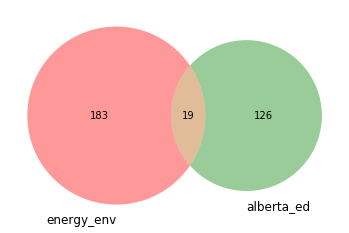

In [213]:
""" 
Since the variable "collection" has 16 different archives, we can use the index variable to choose two. When you 
have two collections, then Compare will provide you with a venn diagram with two variables.

You can find out the content inside the circles by using V2_[A, B or AB].


(V2_A (V2_AB) V2_B)

"""

#Two collections will produce a two-way Venn diagram showing the cross over in terms of links.
#Since collection is a dict() no need to include names.
compare1 = Compare(collection, index=[4,7])
print("Links in Common (there are "+ str(len(compare1.V2_AB)) + ") : " + str(compare1.V2_AB))

Links that both collections have in common: newrelic.com , dublincore.org , w3.org , addthis.com , facebook.com , wordpress.org , google-analytics.com , ab.ca , gc.ca , bc.ca , purl.org , schema.org , adobe.com , alberta.ca , google.com , youtube.com , apple.com , gmpg.org , w.org 


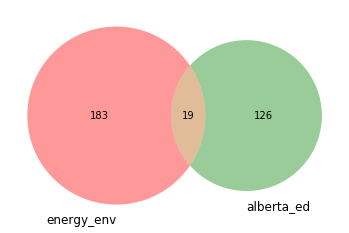

In [214]:
#Although you can add your own names if you want to ...  (recall "names" is x.upper()))

compare1 = Compare(collection, names=names, index=[4,7] )
print("Links that both collections have in common: " + ", ".join(compare1.V2_AB))

Links that all collections have in common: www.youtube.com 


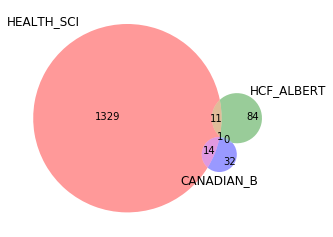

In [215]:
# What happens with three collections
compare2 = Compare(comparit, names, [2,0,5])
print("Links that all collections have in common: " + ', '.join(compare2.V3_ABC))

['humanities', 'alberta_fl', 'ottawa_sho', 'web_archiv', 'alberta_ed', 'energy_env']


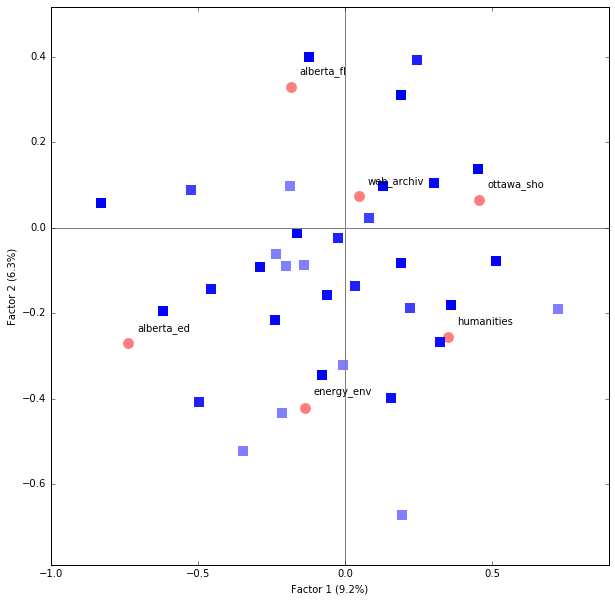

In [24]:
"""
When four or more collections are added, we switch to correspondence analysis. Correspondence analysis is a 
popular way to visualize relationships under two categories.  In our case, we have the collections and the
links contained (or not contained) within the them. 

In this case, the collections have been named and are represented by red circles.  The blue squares represent links that
two or more of the collections have in common, I have not included names here because there are too many.

Focussing on the red circles, when two collections are close together in the analysis they tend to have more links
in common. 

You can also consider the dimensions. In theory, there are as many dimensions of analysis as there are collections.
In practice, you can only show the top two most explanatory dimensions (see inertia scores below).  The dimensions 
sometimes can demonstrate factors in real life.  For example, in the example below, we have the Ottawa shootings on 
one side of the horizontal axis, and heritage community on the other so it appears that there is a dimension that 
ranges from federal focus (left of the y axis) to Alberta focus (right of the y axis).

On the vertical axis, it seems like you have prairie province related materials. More study would be necessary, but 
perhaps this is a dimension for grassroots related collections versus more organizational focussed ones.

Because you have these axes, one can also examine the quadrants as representing some aspect of the collections. 
Top left is empty.  Top right is prairie province related.  Bottom right is Alberta-focussed.  Bottom left is federal /
Canada wide.

There are also some percentage scores associated with each factor.  Given that we are seeing only 10.9 & 11%
respectively, perhaps some other form of analysis would be more effective than links.

From a collection evaluation perspective, it might be worth examining the prairie provinces and idle no more 
collections for significant cross-over, or perhaps to ensure that they have some cross-references. However, some
caution is necessary to ensure that the cross-over occurs due to meaningful reasons rather than some accident of 
Internet behavior (eg. maybe YouTube is used more frequently by those collections).

"""

# With more than three collections, the output switches to correspondence analysis.
# Katherine Faust offers a great overview of the method here:
# www.socsci.uci.edu/~kfaust/faust/research/articles/articles.htm

# In this case, we've eliminated a few items from the analysis.

compare3 = Compare(collection, names, [i for i, x in enumerate(collection) if i not in [1,3,4,5,7,10,11,12,13,14]])

In [217]:
"""
Inertia is somewhat like an R-squared score for a correspondence graph.  The overall inertia is only 40%, so quite low.
However, the third and fourth dimensions of analysis also seem about as relevant and the first and second.

Later developments will show how to look at the correspondence from these perspectives as well.
"""

# Compare.dimensions store factor values for all the dimensions.  The top two dimensions are shown in the graph above.
# Inertia or the total explantory value of the graph is the sum of all these values.
print ([round(x,3) for x in compare3.dimensions])
print ("Inertia: " + str(sum(compare3.dimensions)))

[0.111, 0.10100000000000001, 0.055, 0.048000000000000001, 0.0080000000000000002]
Inertia: 0.322701944391


In [218]:
# Compare.response stores the table that these scores are based on (I've selected only 5 items for clarity)
#If REMOVE_SINGLES is not FALSE, then no row should contain fewer than two "TRUES".

print (compare3.response[10:15])

                          hcf_albert lfrancopho energy_env web_archiv  \
alberta.ca                      True       True       True       True   
albertahealthservices.ca       False       True      False       True   
albertasource.ca                True      False      False       True   
aljazeera.com                  False       True      False       True   
amazon.com                      True       True      False       True   

                          canadian_p humanities  
alberta.ca                     False      False  
albertahealthservices.ca       False      False  
albertasource.ca               False      False  
aljazeera.com                  False      False  
amazon.com                      True      False  


In [219]:
"""
Let's do the same thing with a different dataset:
 
 Name Entity Recognition (NER) offers a way of identifying locations named within the collections.  
 So we have data in csv format like this:
 
CPP 201508,Sum of Frequency
Canada ,283162
Ontario ,34197
United States,32008
Ottawa ,30233
Toronto ,18787
Alberta,17015
British Columbia ,13181
Manitoba,11332
Hawaiian ,10110
QUEBEC,9633
Vancouver,9442

"""


#initialise vars:
loc_collection = dict()
loc_collection_2 = dict()
loc_var = dict()

#establish the data folder
loc_path = "../../NER/"

#get the files
for loc_filename in os.listdir(loc_path):
    with open(loc_path+loc_filename, "r", encoding="utf-8", errors="ignore") as loc_file:
        print(loc_filename)
        loc_collect = [row[0] for row in csv.reader(loc_file)]
        loc_collection[loc_filename[0:10]] = (loc_collect)


#Just separate the names and values for now.
loc_comparit = [x for x in loc_collection.values()]
loc_names = [x.upper() for x in loc_collection.keys()]

CPP-201508-locations.csv
CPP-201511-locations.csv
ELXN42-201601-locations.csv


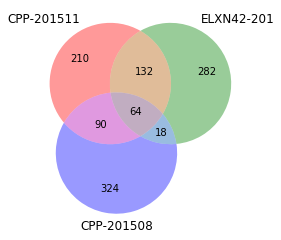

In [220]:
loc_compare_1 = Compare(loc_collection)
#print ("Locations in all Three collections: \n\n" + ", ".join(loc_compare_1.V3_ABC) + "\n ... \n")
#print ("in Just the First (top Left): \n\n" + ", ".join(loc_compare_1.V3_A) + "\n ... \n")
#print ("in top left and bottom \(purple section\): \n\n" + ", ".join(loc_compare_1.V3_AC) + "\n ... \n")
#print ("in top right and bottom \(light blue\): \n\n" + ", ".join(loc_compare_1.V3_BC) + "\n ... \n")

In [221]:
""" 
Now let\'s try to use the dates in our analysis.  This brings up the power a little to use multiple correspondence 
analysis.

((201601,linkis.com),11102), 
((201601,m.youtube.com),8764),
((201601,www.youtube.com),7481)

"""

#initialise vars:
dat_collection = dict()
dat_collection_2 = dict()
dat_var = dict()
dat_collect = dict()
#establish the data folder
dat_path = "assembled/"
urls = []

#get the files
for dat_filename in os.listdir(dat_path):
    with open(dat_path+dat_filename, "r") as dat_file:
        print (dat_filename)
        urls.append(list({(dat_filename[0:10], line.translate(str.maketrans(')'," ")).split(",")[0][2:6], line.translate(str.maketrans(')'," ")).split(",")[1]) for line in dat_file.readlines()}))

""" This produces something like this:
[ { (COLLECTION_NAME, DATE, URL)}]  (the {} is to make it unique.)

"""

elxn42-all.txt
health_sciences_grey_literature-all.txt
canadian_business_grey_literature-all.txt
web_archive_general-all.txt
alberta_floods_2013-all.txt
heritage_community_foundation-all.txt
hcf_alberta_online_encyclopedia-all.txt
alberta_education_curriculum-all.txt
alberta_oil_sands-all.txt
humanities_computing-all.txt
idle_no_more-all-urls.txt
ottawa_shooting_october_2014-all.txt
energy_environment-all.txt
prarie_provinces-all.txt
canadian_political_parties.txt
lfrancophonie_de_louest_canadien-all.txt


' This produces something like this:\n[ { (COLLECTION_NAME, DATE, URL)}]  (the {} is to make it unique.)\n\n'

yay mca


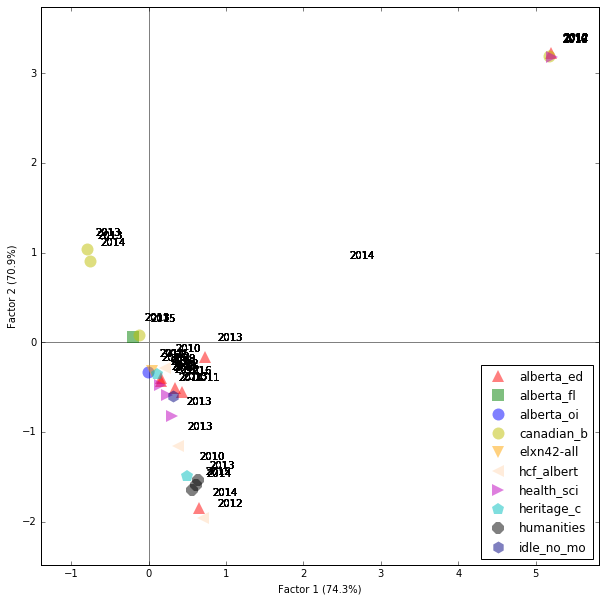

[  7.42573991e-01   7.09111089e-01   6.54544371e-01   5.04112497e-01
   3.73895614e-01   2.53858531e-01   2.46764536e-01   1.92372552e-01
   1.28267468e-01   1.19078760e-01   9.87132274e-02   9.15166613e-02
   8.65010102e-02   7.32555773e-02   6.55122320e-02   6.14897740e-02
   5.67263574e-02   5.41532268e-02   4.79922522e-02   3.99529778e-02
   3.85953016e-02   3.49825867e-02   3.35676173e-02   1.55765097e-02
   1.22464750e-02   9.29235299e-03   7.15620360e-03   3.62699043e-03
   2.66510988e-03   1.91655615e-03   5.33673696e-04]
                www.masslive.com  archive.org  www.collective-evolution.com   \
Collection Date                                                                
health_sci 2014             False        False                         False   
           2012             False        False                         False   
           2015              True         True                          True   
           2013             False        False                  

In [222]:
"""  This provides a graph that shows the dates (labels) in action by collection (shape/color).  It is also possible to show the 
collections by date if desired.
"""

compare4 = Compare(urls, index=[0,1,2,3,4,5,6,7,8,9,10])
print(compare4.dimensions)
print(compare4.response[0:10])

In [1]:
#Unit tests to be removed later.

import unittest

class CompareTests(unittest.TestCase):
    
    collection1 = ["google", "apple", "microsoft", "msn", "napster", "oracle", "amazon", "ibm"]
    collection2 = ["google", "pear", "thebeatles", "thepogues", "napster", "apple", "cow"]
    collection3 = ["google", "apple", "msn", "skunk", "beaver", "wolf", "cow"]
    collection4 = ["apple", "jump", "walk", "run", "saunter", "skunk", "napster"]
    collection5 = ["pear", "wolf", "jive", "tango"]
    collection6 = ["google", "apple", "msn", "thepogues", "napster", "wolf", "amazon", "tango"]
    one_collect = [collection1]
    two_collect = [collection1, collection2]
    three_collect = [collection1, collection2, collection3]
    all_collect = [collection1, collection2, collection3, collection4, collection5, collection6]
    
    def test_one (self):
        print("test error with one collection")
        self.assertTrue(Compare(self.one_collect), "Need at least two collections to compare results.")
        
    def test_two (self):
        print ("test results for two collections")
        self.assertTrue(Compare(self.two_collect).response.subset_labels[1].get_text(), 4)
        self.assertTrue(Compare(self.two_collect).response.subset_labels[0].get_text(), 5)
        self.assertTrue(Compare(self.two_collect).response.subset_labels[2].get_text(), 3)
    
    def test_three (self):
        print("test results for three")
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 4)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[1].get_text(), 3)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 1)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 3)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 1)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 1)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 2)
    
    def test_all (self):
        print("test results for more than three")
        test=Compare(self.all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False)
        self.assertTrue(list(Compare(self.all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False).response.iloc[1].values), 
                        [True, True, True, True, False, True])
        self.assertTrue(list(Compare(self.all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False).response.ix['amazon'].values),
                        [True, False, False, False, False, True])
        self.assertTrue(list(Compare(self.all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False).response.iloc[5].values),
                        [True, False, False, False, False, False])
        
        
        

suite = unittest.TestLoader().loadTestsFromTestCase(CompareTests)
unittest.TextTestRunner().run(suite)
        

EEEE

test results for more than three
test error with one collection
test results for three
test results for two collections



ERROR: test_all (__main__.CompareTests)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-1-4488d75fad46>", line 40, in test_all
    test=Compare(self.all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False)
NameError: name 'Compare' is not defined

ERROR: test_one (__main__.CompareTests)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-1-4488d75fad46>", line 20, in test_one
    self.assertTrue(Compare(self.one_collect), "Need at least two collections to compare results.")
NameError: name 'Compare' is not defined

ERROR: test_three (__main__.CompareTests)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-1-4488d75fad46>", line 30, in test_three
    self.assertTrue(Compare(self.three_collect).response.subset_labels[0].ge

<unittest.runner.TextTestResult run=4 errors=4 failures=0>

In [12]:
    
compare3.ca.loc[:,'SUFFIX'] = pd.Series(var, index=compare3.ca.index)
print (compare3.ca)
compare3.ca.to_csv("output.csv",  encoding='utf-8')


           Factor Score           Squared cosines      Contributions x 1000  \
                      1         2               1    2                    1   
alberta_oi      1.05586 -0.343164             NaN  NaN                  NaN   
web_archiv   -0.0681805  0.397215             NaN  NaN                  NaN   
health_sci    0.0286926  0.423649             NaN  NaN                  NaN   
prarie_pro    -0.137887 -0.173909             NaN  NaN                  NaN   
canadian_b      1.11153 -0.534136             NaN  NaN                  NaN   
hcf_albert     0.392565  0.317313             NaN  NaN                  NaN   
lfrancopho     -0.31003 -0.266426             NaN  NaN                  NaN   
energy_env     0.911012  -0.25989             NaN  NaN                  NaN   
ottawa_sho     0.256949  0.642581             NaN  NaN                  NaN   
alberta_ed     0.385476  0.299072             NaN  NaN                  NaN   

                SUFFIX  
              2         
a